# The 8-puzzle

The following project is a simple application of the A* algorithm to the sliding puzzle problem:

https://en.wikipedia.org/wiki/Sliding_puzzle

It was intented as an exercise in dynamic programming.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def make_default_board(rank=3):
    """
    e.g. (depending on rank) :
    0 1 2
    3 4 5
    6 7 8        
    """
    return np.arange(rank**2).reshape(rank,rank)

def board(seq):
    rank = int(np.sqrt(len(seq)))
    return np.array(seq).reshape(rank, rank)

def move_zero(b,r0,c0,r,c):
    b1 = np.copy(b)
    b1[r0,c0] = b1[r,c]
    b1[r,c] = 0
    return b1

def neighbours(b, rank):
    r0, c0 = np.where(b==0)[0][0], np.where(b==0)[1][0] #position of 0
    n_list = []
    for (r,c) in [(r0+1,c0), (r0-1,c0), (r0,c0+1), (r0,c0-1)]:
        if -1<r and r<rank and -1<c and c<rank:
            n_list.append(move_zero(b,r0,c0,r,c))
    return n_list
    
def make_random_board(rank=3):
    b = make_default_board(rank)
    random_steps = random.randint(100,200) #use a random number of steps to circumvent 2-periodicity; the latter WILL come back to bite us, but it is still desirable to be able to generate all the grids
    for s in range(random_steps):
        n_list = neighbours(b,rank)
        b = n_list[random.randint(0,len(n_list)-1)]
    return b


b = make_random_board()
print(b)
neighbours(b,3)

[[8 3 0]
 [1 7 2]
 [5 4 6]]


[array([[8, 3, 2],
        [1, 7, 0],
        [5, 4, 6]]),
 array([[8, 0, 3],
        [1, 7, 2],
        [5, 4, 6]])]

A* needs heuristic distance estimates and we will construct them as follows. Using the $ |\delta x |+|\delta y|$ metric on the board, each move displaces a single tile by the distance of 1 and hence the number of moves needed to transform b1 into b2 is greater or equal to the sum of required displacements of individual tiles. 

In [270]:
def h(b1,b2,rank):
    h_val = 0
    for n in range(1,rank**2):
        r1, c1 = np.where(b1==n)[0][0], np.where(b1==n)[1][0]
        r2, c2 = np.where(b2==n)[0][0], np.where(b2==n)[1][0]
        h_val += abs(r1-r2)+abs(c1-c2)
    return h_val

b1 = make_random_board(4)
b2 = make_random_board(4)
print(b1,"\n\n",b2)
h(b1,b2,4)

[[ 4  7  2  3]
 [ 5  9  1 13]
 [ 8 14 15  6]
 [12 11  0 10]] 

 [[ 1  2 11  6]
 [ 4  9 10  5]
 [13  3  8  0]
 [14 12 15  7]]


36

To store our distance estimates, we will want to hash the board arrays, which requires changing them to some other format (here we choose integers). While it may not be the most efficient to go back and forth between the two different forms, it is certainly convenient.

In [271]:
def int_id(b, rank):
    return np.sum(b.reshape(rank**2) * (rank**2+1)**np.arange(rank**2))

print(b)
int_id(b,3)

[[8 3 0]
 [1 7 2]
 [5 4 6]]


645271038

Before we proceed to solutions, there is one remark to be made. A simple analysis shows that not all transitions are possible, for example
$$
\begin{matrix} 0 & 1 \\ 2 & 3\end{matrix} \qquad \to \qquad \begin{matrix} 3 & 1 \\ 2 & 0\end{matrix}
$$
cannot be done as it is an odd permutation (0 is transposed with 3) and yet requires an even number of moves, which can be seen by colouring the grid like a chessboard. The above reasoning can be easily generalised : moving from one configuration to another is impossible if the parity of the required displacement $|\delta x| + |\delta y|$ of 0 does not match that of the overall permutation we would need to perform.

The above remark allows us to conceive a procedure to filer out (at least some of) the unsolvable puzzles. To determine the sign of the overall permutation, we simply count the total numer of inversions (see https://en.wikipedia.org/wiki/Parity_of_a_permutation#Equivalence_of_the_two_definitions).

In [272]:
def parity(b):
    p = np.where(b==0)[0][0] + np.where(b==0)[1][0] #displacement of 0 -> |x|+|y|
    perm = b.reshape(b.size)
    for i in range(len(perm)):
        for j in range(i+1,len(perm)):
            if perm[j] < perm[i]:
                p += 1
            #endif
        #next j
    #next i
    return p%2

parity(board([3,1,2,0]))

1

In [280]:
def path(start, goal, max_steps = 10000):
    rank = start.shape[0]
    unvisited = [start] #nodes that have been seen but have not yet been visited
    best_f = {} #format   node:dist (the best known distance from start to goal via node)
    best_f_node = {} #for subsequent backtracking
    best_g = {} #the best known distance from start

    best_g[int_id(start,rank)] = 0
    best_f[int_id(start,rank)] = h(start, goal, rank) + 1 #infinity 
    visited = {}

    visited_goal = False
    count = 0
    while not visited_goal and len(unvisited) != 0 and count<max_steps:

        current = unvisited.pop(0) #visit the best unvisited node
        c_id = int_id(current,rank)

        for n in neighbours(current, rank):

            n_id = int_id(n,rank)

            try: #check whether the node has been visited
                visited[n_id]

            except: #unvisited
                h_ng = h(n, goal, rank)
                try: #check whether it has been seen before
                    best_g[n_id]
                except: #add path via current
                    best_g[n_id] = best_g[c_id] + 1
                    best_f[n_id] = best_g[n_id] + h_ng
                    best_f_node[n_id] = current
                    
                    #insert at the right place in the unvisited list
                    ind = 0
                    while ind<len(unvisited) and best_f[n_id] > best_f[int_id(unvisited[ind],rank)]:
                        ind += 1
                    unvisited.insert(ind,n)
                else:
                    f_via_current = best_g[c_id] + 1 + h_ng
                    if f_via_current < best_f[n_id]: #a bbetter solution was found
                        best_g[n_id] = best_g[c_id] + 1
                        best_f[n_id] = f_via_current
                        best_f_node[n_id] = current
                        
                        #re-insert at the right place in the unvisited list
                        ind = 0
                        while ind<len(unvisited) and best_f[n_id] > best_f[int_id(unvisited[ind],rank)]: #insert at right place
                            ind += 1
                        unvisited.insert(ind,n)
                        #remove the other occurence
                        ind += 1
                        while False in (n == unvisited[ind]):
                            ind += 1
                        unvisited.pop(ind)

                best_g[n_id] = best_g[c_id] + 1

            else: #visited, ignore this neighbour
                pass
            #end try
        #next neighbour
        if False not in (current == goal):
            visited_goal = True
        count += 1
    #endwhile
    if count >= max_steps:
        print("Max number of steps", max_steps, "reached for", b1, b2)
    try:
        best_f[int_id(goal,rank)]
    except:
        return -1, [] #error
    else:
        solution = [goal]
        current = goal
        while False in (current == start):
            current = best_f_node[int_id(current,rank)]
            solution.append(current)
        return best_f[int_id(goal,rank)], solution[::-1]
    #endif
#endfunction

In [274]:
b1 = make_default_board()
b1

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [275]:
def random_puzzle(rank=3, default_goal = False):
    if default_goal:
        b2 = make_default_board(rank)
    else:
        b2 = make_random_board(rank)
    #endif
    b1 = make_random_board(rank)
    while parity(b1) != parity(b2):
        b1 = make_random_board(rank)
    return b1, b2

b1, b2 = random_puzzle(default_goal=False)
print(h(b1,b2,3))
path(b1,b2)

13


(19,
 [array([[0, 5, 7],
         [4, 6, 1],
         [8, 3, 2]]),
  array([[5, 0, 7],
         [4, 6, 1],
         [8, 3, 2]]),
  array([[5, 7, 0],
         [4, 6, 1],
         [8, 3, 2]]),
  array([[5, 7, 1],
         [4, 6, 0],
         [8, 3, 2]]),
  array([[5, 7, 1],
         [4, 6, 2],
         [8, 3, 0]]),
  array([[5, 7, 1],
         [4, 6, 2],
         [8, 0, 3]]),
  array([[5, 7, 1],
         [4, 6, 2],
         [0, 8, 3]]),
  array([[5, 7, 1],
         [0, 6, 2],
         [4, 8, 3]]),
  array([[5, 7, 1],
         [6, 0, 2],
         [4, 8, 3]]),
  array([[5, 0, 1],
         [6, 7, 2],
         [4, 8, 3]]),
  array([[5, 1, 0],
         [6, 7, 2],
         [4, 8, 3]]),
  array([[5, 1, 2],
         [6, 7, 0],
         [4, 8, 3]]),
  array([[5, 1, 2],
         [6, 7, 3],
         [4, 8, 0]]),
  array([[5, 1, 2],
         [6, 7, 3],
         [4, 0, 8]]),
  array([[5, 1, 2],
         [6, 0, 3],
         [4, 7, 8]]),
  array([[5, 0, 2],
         [6, 1, 3],
         [4, 7, 8]]),
  a

In [282]:
b1, b2 = random_puzzle(3,default_goal=False)
print(h(b1,b2,3))
print(b1)
print(b2)
path(b1,b2)

14
[[3 2 1]
 [8 5 4]
 [6 7 0]]
[[4 2 3]
 [1 6 5]
 [7 8 0]]


(28,
 [array([[3, 2, 1],
         [8, 5, 4],
         [6, 7, 0]]),
  array([[3, 2, 1],
         [8, 5, 4],
         [6, 0, 7]]),
  array([[3, 2, 1],
         [8, 0, 4],
         [6, 5, 7]]),
  array([[3, 0, 1],
         [8, 2, 4],
         [6, 5, 7]]),
  array([[3, 1, 0],
         [8, 2, 4],
         [6, 5, 7]]),
  array([[3, 1, 4],
         [8, 2, 0],
         [6, 5, 7]]),
  array([[3, 1, 4],
         [8, 0, 2],
         [6, 5, 7]]),
  array([[3, 1, 4],
         [0, 8, 2],
         [6, 5, 7]]),
  array([[0, 1, 4],
         [3, 8, 2],
         [6, 5, 7]]),
  array([[1, 0, 4],
         [3, 8, 2],
         [6, 5, 7]]),
  array([[1, 4, 0],
         [3, 8, 2],
         [6, 5, 7]]),
  array([[1, 4, 2],
         [3, 8, 0],
         [6, 5, 7]]),
  array([[1, 4, 2],
         [3, 0, 8],
         [6, 5, 7]]),
  array([[1, 4, 2],
         [3, 5, 8],
         [6, 0, 7]]),
  array([[1, 4, 2],
         [3, 5, 8],
         [6, 7, 0]]),
  array([[1, 4, 2],
         [3, 5, 0],
         [6, 7, 8]]),
  a

In [263]:
h_val = []
d_val = []
for i in range(20):
    print(i)
    b1, b2 = random_puzzle(3,default_goal=False)
    d, sol = path(b1,b2)
    h_val.append(h(b1,b2,3))
    d_val.append(d)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


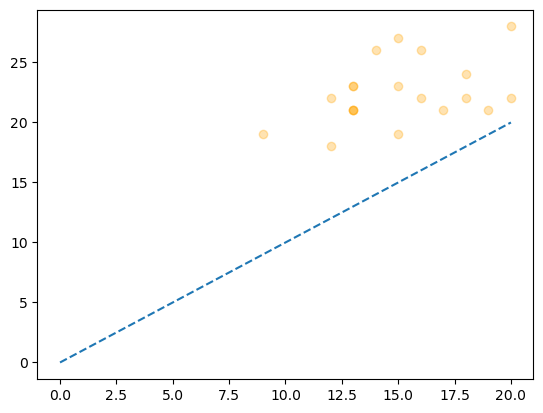

In [267]:
plt.scatter(h_val,d_val, alpha=0.3, color='orange')
plt.plot([0,max(h_val)],[0,max(h_val)], "--")
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.draw()